In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [394]:
import numpy as np
import cv2

#specify
CAR_PATH = ''
LP_PATH = ''

#read car in grayscale, color and threshold and LP in grayscale
car = cv2.imread(CAR_PATH,0)
lp = cv2.imread(LP_PATH,0)


# 16 different template sizes - greater chance of success


def lp_finder_16(car):
    
    '''Function which returns list of  16 grayscale licence plate images, cropped from image of a car.
    Uses template matching, with 16 different template LP shapes.
    
    Params:
    car - grayscale image of a car
    lp - grayscale image of template licence plate'''
    
    #reshape car image to 600x400 - not used here, original images give better results if not huge
    #reshaping changes length and height ratios, which decreases algorithm efficiency 
    #since LP template shapes are hardcoded
    car_r = cv2.resize(car, (600,400))
    #thresholding car image
    car_th = cv2.threshold(car, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    car_canny = cv2.Canny(car_th, 200,400)
    
    
    #for 16 different LP sizes
    #getting resizing values for test licence plate
    shape1 = np.arange(150,230,5)
    shape2 = np.arange(56,84,1.5)
    #shape2 contains floats, converting to ints
    shape3 = []
    for i in shape2:
        shape3.append(int(i))
    #creating tuples (shape1,shape3) in single list
    sizes = zip(shape1,shape3)
    sizes = list(sizes)
    
    #creating lp mask
    lp = np.zeros((70,170), dtype=np.uint8)
    lp = cv2.rectangle(lp, (3,3), (167,67), 255, -1)
    # list of thresholded plates in all sizes
    plates = []
    for i in range(0, len(sizes)):
        plates.append(cv2.resize(lp, sizes[i]))

    #matching car with each LP size
    matches = []
    #list of matches for each size
    for i in plates:
        matches.append(cv2.matchTemplate(car_canny, i, cv2.TM_CCOEFF))
    
    #appends location of matched squares to list, inverted to (x,y), for thresh
    #minMaxLoc finds maximum for each match
    locs = []
    for i in range(0, len(matches)):
        locs.append(tuple(cv2.minMaxLoc(matches[i])[3]))
    
    
    #creates masks for images, where only LP remains
    masks = []
    for i in range(0,len(plates)):
        black = np.zeros(car.shape, dtype=np.uint8)
        black = cv2.rectangle(black, locs[i], (locs[i][0]+plates[i].shape[1], locs[i][1]+plates[i].shape[0]), 255, -1)
        masks.append(black)
    
    #keeping only LP - cropped list contains all cropped images of LPs
    cropped = []
    for i in range(0,len(plates)):
        masked = cv2.bitwise_and(car, car, mask=masks[i])
        x,y = np.where(masked!=0)
        topx = x.min()
        bottomx = x.max()
        topy=y.min()
        bottomy=y.max()
        crop = masked[topx:bottomx,topy:bottomy]
        cropped.append(crop)
        
    return(cropped)   

In [1519]:
def lp_finder_7(car):
    
    '''Function which returns list of 6 Otsu thresholded licence plate images, cropped from image of a car.
    Uses template matching, with 6 different template shapes of white rectange with black edges.
    
    Params:
    car - grayscale image of a car'''
    

    #thresholding car image
    car_th = cv2.threshold(car, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    #getting canny
    car_canny = cv2.Canny(car_th, 200,400)
    
    #for 7 different LP sizes
    #getting resizing values for test licence plate
    shape1 = np.arange(150,235,12.5)
    shape2 = np.arange(56,80,3)
    #creating tuples (shape1,shape3) in single list
    shape3 = []
    for i in shape1:
        shape3.append(int(i))
    sizes = zip(shape3,shape2)
    sizes = list(sizes)
    sizes
    
    #creating lp mask - white rectangle with black edges
    lp = np.zeros((56,150), dtype=np.uint8)
    lp = cv2.rectangle(lp, (3,3), (147,53), 255, -1)
    # list of thresholded plates in all sizes
    plates = []
    for i in range(0, len(sizes)):
        plates.append(cv2.resize(lp, sizes[i]))

    #matching car with each LP size
    matches = []
    #list of matches for each size
    for i in plates:
        matches.append(cv2.matchTemplate(car_canny, i, cv2.TM_CCOEFF))
    
    #appends location of matched squares to list, inverted to (x,y), for thresh
    #minMaxLoc finds maximum for each match
    locs = []
    for i in range(0, len(matches)):
        locs.append(tuple(cv2.minMaxLoc(matches[i])[3]))
    
    
    #creates masks for images, where only LP remains
    masks = []
    for i in range(0,len(plates)):
        black = np.zeros(car.shape, dtype=np.uint8)
        black = cv2.rectangle(black, locs[i], (locs[i][0]+plates[i].shape[1], locs[i][1]+plates[i].shape[0]), 255, -1)
        masks.append(black)
    
    #keeping only LP - cropped list contains all cropped images of LPs
    cropped = []
    for i in range(0,len(plates)):
        masked = cv2.bitwise_and(car, car, mask=masks[i])
        x,y = np.where(masked!=0)
        topx = x.min()
        bottomx = x.max()
        topy=y.min()
        bottomy=y.max()
        crop = masked[topx:bottomx,topy:bottomy]
        cropped.append(crop)
        
    return(cropped)

In [1520]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract as tess
import string
from statistics import mode
import statistics

In [1521]:
#finding most frequent value
from collections import Counter
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 

In [2623]:
#reading image for testing
car = cv2.imread('16.jpg', 0)
regs7 = lp_finder_7(car)

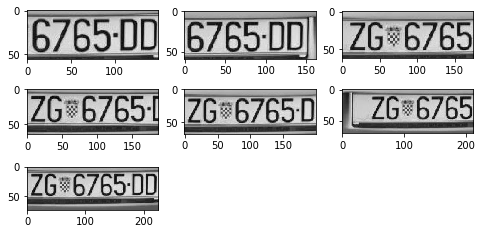

In [2625]:
plt.figure(figsize=(8,4))
for i in range(len(regs7)):
    plt.subplot(3,3,i+1)
    plt.imshow(regs7[i], cmap='gray')

In [2626]:
#making thresholded plates for tesseract
regs7_th = []
for i in regs7:
    regs7_th.append(cv2.threshold(i, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1])
# adding median filtering (denoiser) for each image
for i in range(len(regs7_th)):
    regs7_th.append(cv2.medianBlur(regs7_th[i], 5))

In [2627]:
#allowed characters in plates
#letters
char = list(string.ascii_uppercase)
#numbers
for i in range (0,10):
    char.append(str(i))
 #removing non croatian letters
char.remove('Q')
char.remove('W')
char.remove('X')
char.remove('Y')
print(char)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [2628]:
#making list of all things tesseract reads
all_regs = []
#reading each image
for i in range(len(regs7_th)):
    all_regs.append(tess.image_to_string(regs7_th[i], lang='eng'))
    #uppercasing
    for j in range(len(all_regs)):
        all_regs[j] = all_regs[j].upper()
#getting rid of all non sucessful reads (i.e. if empty string is returned)
all_regs_clean = []
for i in all_regs:
    if i != '':
        all_regs_clean.append(i)

In [2629]:
#removing all not allowed characters (those not in char)
for i in range(len(all_regs_clean)):
    for j in all_regs_clean[i]:
        if j not in char:
            all_regs_clean[i] = all_regs_clean[i].replace(j,'')
all_regs_clean

['66500', '266651', '76267650', 'IE6500', '266765', '267676500EE']

In [2630]:
#ity segment of licence plate
city = []
#list of all croatain cities, including some common misreads (O and D)
cro_cities = ['BJ', 'BM', 'CK', 'DA', 'OA', 'DE', 'OE', 'DJ', 'OJ', 'DU', 'OU', 'GS',
             'IM', 'KA', 'KC', 'KR', 'KT', 'KZ', 'MA', 'NA',
             'NG', 'OG', 'DG', 'OS', 'DS', 'PU', 'PZ', 'RI', 'SB', 'SK','SL',
              'ST', 'SI', 'VK', 'VT', 'VU', 'VZ', 'ZD', 'ZO', 'ZG', 'ZU']
#city as first 2 letters read
for i in all_regs_clean:
    city.append(i[0:2])
#replacing numbers with letters
for i in range(len(city)):
    for j in city[i]:
        if j == '1':
            city[i] = city[i].replace(j,'I')
        if j == '2':
            city[i] = city[i].replace(j,'Z')
        if j == '3':
            city[i] = city[i].replace(j,'G')
        if j == '5':
            city[i] = city[i].replace(j,'S')
        if j == '6':
            city[i] = city[i].replace(j,'G')
        if j == '7':
            city[i] = city[i].replace(j,'Z')
        if j == '8':
            city[i] = city[i].replace(j,'B')
        if j == '0':
            city[i] = city[i].replace(j,'O')
#keeping only those from cro cities list
city2 = []
for i in city:
    if i in cro_cities:
        city2.append(i)
#reading 2nd and 3rd characters if 1st and 2nd fail
if city2 == []:
    #third variable - tells if 1and2 or 2and3 are used as city letters
    third = True
    for i in all_regs_clean:
        city.append(i[1:3])
    for i in range(len(city)):
        for j in city[i]:
            if j == '1':
                city[i] = city[i].replace(j,'I')
            if j == '2':
                city[i] = city[i].replace(j,'G')
            if j == '3':
                city[i] = city[i].replace(j,'B')
            if j == '5':
                city[i] = city[i].replace(j,'S')
            if j == '6':
                city[i] = city[i].replace(j,'G')
            if j == '7':
                city[i] = city[i].replace(j,'Z')
            if j == '8':
                city[i] = city[i].replace(j,'B')
            if j == '0':
                city[i] = city[i].replace(j,'O')
    city2 = []
    for i in city:
        if i in cro_cities:
            city2.append(i)
#third set to false if first two letters are used
else:
    third = False
#cleaning D and O
for i in range(len(city2)):
    if city2[i] == 'OA':
        city2[i] = 'DA'
    if city2[i] == 'OU':
        city2[i] = 'DU'
    if city2[i] == 'OE':
        city2[i] = 'DE'
    if city2[i] == 'OJ':
        city2[i] = 'DJ'
    if city2[i] == 'DS':
        city2[i] = 'OS'
    if city2[i] == 'DG':
        city2[i] = 'OG'
city2

['ZG', 'ZG', 'ZG', 'ZG']

In [2631]:
#getting most frequent as true value
city = most_frequent(city2)
city

'ZG'

In [2632]:
#list of numbers
number = []
#list of allowed numeric characters (0-9)
numchar = []
for i in range(10):
    numchar.append(str(i))
#getting read characters into number list, to try to infer
if third == False:
    for i in all_regs_clean:
        number.append(i)
else:
    for i in all_regs_clean:
        number.append(i)
number

['66500', '266651', '76267650', 'IE6500', '266765', '267676500EE']

In [2633]:
#throwing letters out
for i in range(len(number)):
    for j in number[i]:
        if j not in numchar:
            number[i] = number[i].replace(j,'')
number

['66500', '266651', '76267650', '6500', '266765', '267676500']

In [2634]:
#keeping only numbers with length 3 or 4
number2 = []
for i in number:
    if len(i) == 3 or len(i) == 4:
        number2.append(i)
number2

['6500']

In [2635]:
#ending 2 letters segment
#try to keep only ones with length 1 and 2
end = []
#appending last 2 chars
for i in all_regs_clean:
    end.append(i[-2:])
for i in range(len(end)):
    for j in end[i]:
        if j == '1':
            end[i] = end[i].replace(j,'I')
        if j == '2':
            end[i] = end[i].replace(j,'Z')
        if j == '3':
            end[i] = end[i].replace(j,'B')
        if j == '5':
            end[i] = end[i].replace(j,'S')
        if j == '6':
            end[i] = end[i].replace(j,'G')
        if j == '7':
            end[i] = end[i].replace(j,'Z')
        if j == '8':
            end[i] = end[i].replace(j,'B')
        if j == '0':
            end[i] = end[i].replace(j,'O')
end

['OO', 'SI', 'SO', 'OO', 'GS', 'EE']

In [2636]:
final = []
final2 = []
#combining city with every possible number
for i in number2:
    final.append(city+i)
#combining all city-numbers with each possible ending 
for i in final:
    for j in end:
        final2.append(i+j)
#removing duplicates
final2 = set(final2)
final2 = list(final2)
final2

['ZG6500SI', 'ZG6500SO', 'ZG6500GS', 'ZG6500OO', 'ZG6500EE']

In [2637]:
import PIL as pil

In [699]:
a = pil.Image.open('r3.jpg')

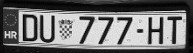

In [700]:
a

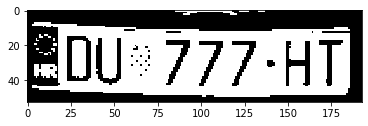

In [743]:
b = cv2.imread('r3.jpg',0)
c = cv2.threshold(b, 70, 255, cv2.THRESH_BINARY)[1]
plt.imshow(c, cmap='gray')

In [745]:
tess.image_to_string(a)

''

In [697]:
tess.image_to_string?